# **Single-Cell RNA-Seq Analysis Project**

In this project, you will work with the `norman` dataset from the `perturbation_data_analysis` exercise:

In [1]:
import pertdata as pt
import scanpy as sc

norman = pt.PertDataset(name="norman", cache_dir_path="data", silent=False)
norman_raw = norman
print(norman)

print(norman.adata)
# print(f"head {norman.adata.obs.head}")
X = norman.adata.X
y_pert = norman.adata.obs["condition"]
y_ctrl = norman.adata.obs["control"]
gene_names = norman.adata.var["gene_name"]

print(f"X.shape={X.shape}")  # type: ignore
print(f"y_pert.shape={y_pert.shape}")
print(f"y_ctrl.shape={y_ctrl.shape}")
print(f"gene_names.shape={gene_names.shape}")


Dataset already cached: /Users/leo/Documents/Workspace/amlg_env/luh_module_amlg_assignment/data/norman
Loading: /Users/leo/Documents/Workspace/amlg_env/luh_module_amlg_assignment/data/norman/norman/perturb_processed.h5ad
PertDataset object
    name: norman
    cache_dir_path: /Users/leo/Documents/Workspace/amlg_env/luh_module_amlg_assignment/data
    path: /Users/leo/Documents/Workspace/amlg_env/luh_module_amlg_assignment/data/norman
    adata: AnnData object with n_obs ✕ n_vars = 91205 ✕ 5045
AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'
X.shape=(91205, 5045)
y_pert.shape=(91205,)
y_ctrl.shape=(91205,)
gene_names.shape=(5045,)


In [ ]:
print(norman.adata.obs.columns.tolist())
print(norman.adata.var)


['condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed']
                    gene_name
gene_id                      
ENSG00000239945  RP11-34P13.8
ENSG00000223764   RP11-54O7.3
ENSG00000187634        SAMD11
ENSG00000187642         PERM1
ENSG00000188290          HES4
...                       ...
ENSG00000198786        MT-ND5
ENSG00000198695        MT-ND6
ENSG00000198727        MT-CYB
ENSG00000273554    AC136616.1
ENSG00000278633    AC023491.2

[5045 rows x 1 columns]
cell_barcode
AAACCTGAGGCATGTG-1     A549_TSC22D1+ctrl_1+1
AAACCTGAGGCCCTTG-1      A549_KLF1+MAP2K6_1+1
AAACCTGCACGAAGCA-1               A549_ctrl_1
AAACCTGCAGACGTAG-1    A549_CEBPE+RUNX1T1_1+1
AAACCTGCAGCCTTGG-1       A549_MAML2+ctrl_1+1
                               ...          
TTTGTCAGTCATGCAT-8     A549_RHOXF2BB+SET_1+1
TTTGTCATCAGTACGT-8       A549_FOXA3+ctrl_1+1
TTTGTCATCCACTCCA-8       A549_CELF2+ctrl_1+1
TTTGTCATCCCAACGG-8      A549_BCORL1+ctrl_1+1
TTTGTCATCTGGCGAC-8      A549_MAP4K3

In [3]:
import pandas as pd

def generate_fixed_perturbation_labels(labels: pd.Series) -> pd.Series:

# Remove "ctrl+" and "+ctrl" matches.
    labels_fixed = labels.str.replace(pat="ctrl+", repl="")
    labels_fixed = labels_fixed.str.replace(pat="+ctrl", repl="")

    return labels_fixed

In [4]:
print(f"Unique perturbations (unfixed): {len(set(norman.adata.obs['condition']))}")

norman.adata.obs["condition_fixed"] = generate_fixed_perturbation_labels(
    labels=norman.adata.obs["condition"]
)

print(f"Unique perturbations (fixed): {len(set(norman.adata.obs['condition_fixed']))}")

Unique perturbations (unfixed): 284
Unique perturbations (fixed): 237


## Filter out double-gene pertubations
Focusing on just single gene pertubatinos to make the analysis easier

In [5]:
filter_mask = ~norman.adata.obs["condition_fixed"].str.contains(r"\+")
indexes_to_keep = filter_mask[filter_mask].index
adata_single = norman.adata[indexes_to_keep].copy()  # type: ignore

In [6]:
print(adata_single)

AnnData object with n_obs × n_vars = 55760 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'


# QC


In [ ]:
# Get the AnnData object from PertDataset
adata = adata_single.copy()
# adata = norman.adata

#  mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

# QC metrics -> braucht man für qc-plots
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

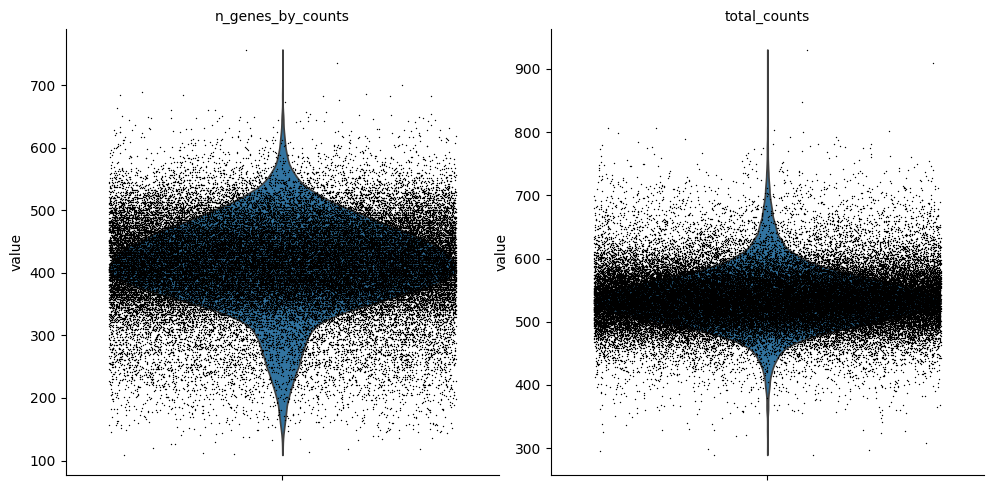

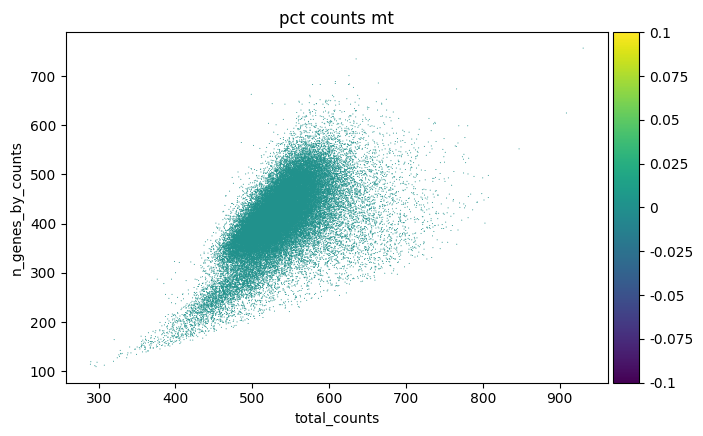

In [27]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], 
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Filter

In [20]:
adata_filtered = adata.copy()
# sc.pp.filter_cells(adata, min_genes=100)
# sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata_filtered, min_genes=200)
sc.pp.filter_genes(adata_filtered, min_cells=3)

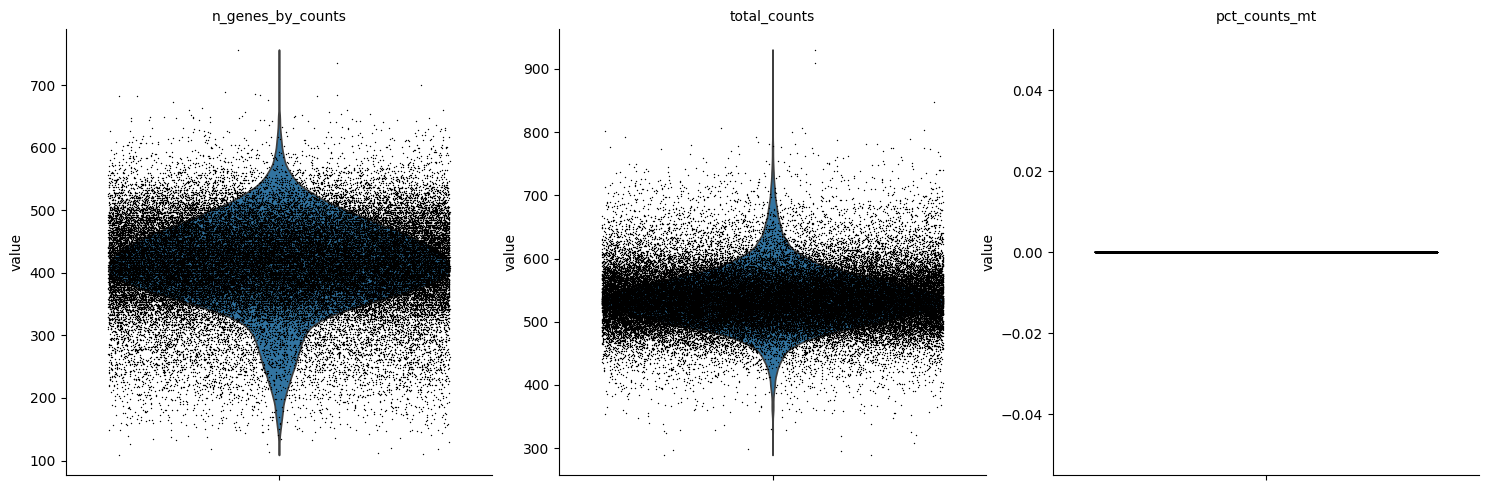

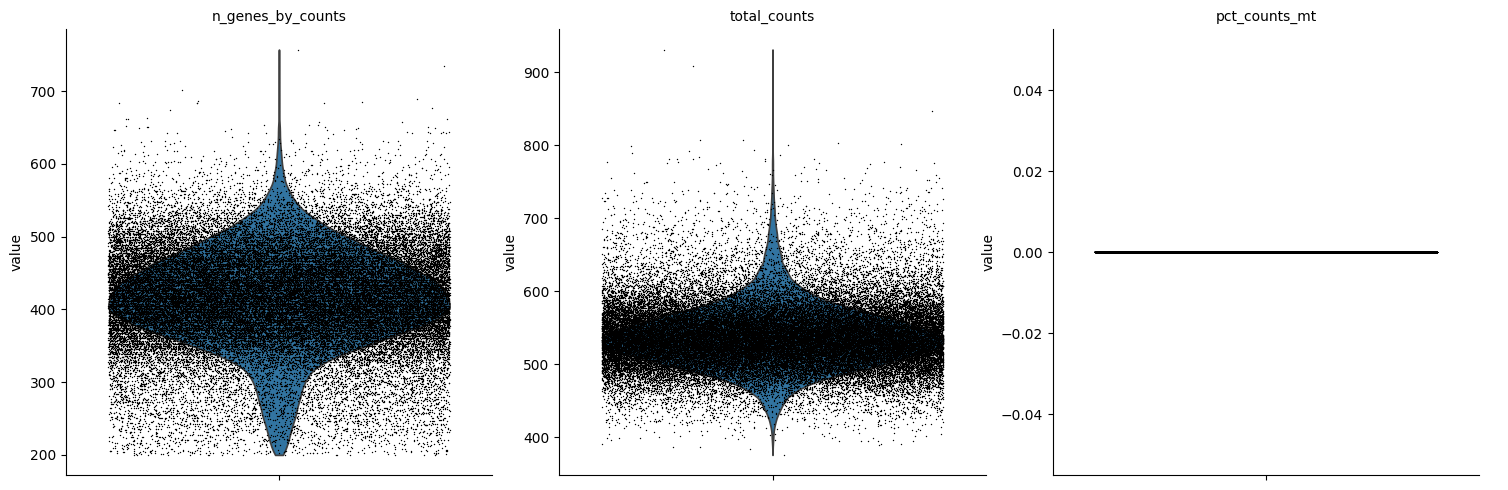

In [ ]:

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
             jitter=0.4, multi_panel=True)
sc.pl.violin(adata_filtered, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
             jitter=0.4, multi_panel=True)


## Doublet Detection

Funktioniert bisher nicht

In [11]:
# predicted_doublets, scores = sc.pp.scrublet(adata, expected_doublet_rate=0.06)

# adata['doublet_scores'] = scores
# adata['predicted_doublets'] = predicted_doublets

# # Doublets entfernen
# adata_removed_doublets = adata[~predicted_doublets, :].copy()

## Normalizing

In [21]:
# Library size normalisieren
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
# Log-transformieren
sc.pp.log1p(adata_filtered)

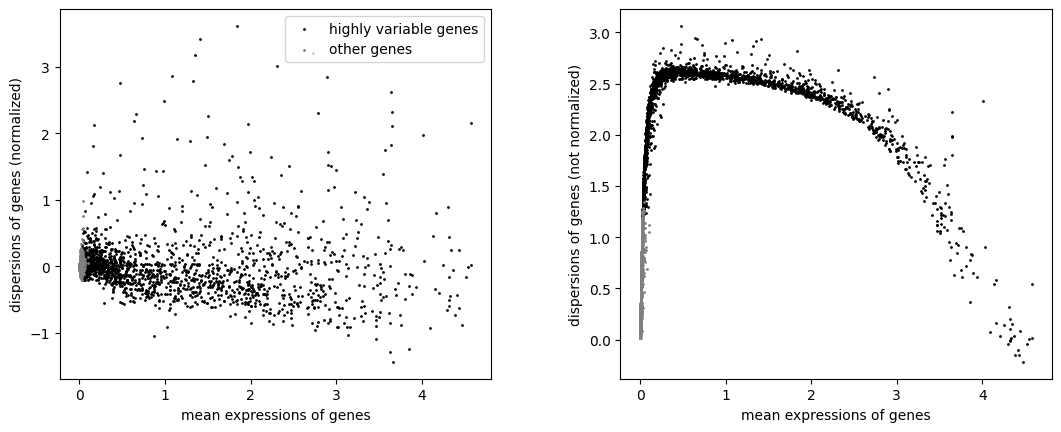

In [ ]:
sc.pp.highly_variable_genes(adata_filtered, n_top_genes=2000, batch_key="condition")
sc.pl.highly_variable_genes(adata_filtered)

Choose one of the following tasks:

**Exploratory Data Analysis and Visualization**

- Objective: Explore the dataset to identify patterns and clusters.
- Tasks:
  - Perform dimensionality reduction using PCA, t-SNE, or UMAP.
  - Visualize gene expression profiles across different conditions or perturbations.
  - Create heatmaps of the top differentially expressed genes.
- Learning Outcomes:
  - Learn to visualize high-dimensional data.
  - Interpret clusters and patterns in the context of biological conditions.

**Machine Learning Classification**

- Objective: Build models to classify samples based on gene expression profiles.
- Tasks:
  - Split the dataset into training and testing sets.
  - Implement classification algorithms.
  - Evaluate model performance using metrics like accuracy, precision, recall, and ROC curves.
- Learning Outcomes:
  - Understand supervised learning techniques.
  - Learn model evaluation and validation strategies.

**Advanced Deep Learning Applications**

- Objective: Apply deep learning techniques to model complex patterns in the data.
- Tasks:
  - Implement autoencoders or variational autoencoders for dimensionality reduction.
  - Explore the use of GANs to generate synthetic gene expression data.
  - Analyze how deep learning models capture nonlinear relationships.
- Learning Outcomes:
  - Gain experience with deep learning frameworks.
  - Understand the applications of deep learning in genomics.